In [2]:
# %load ../notebooks/init.ipy
%reload_ext autoreload
%autoreload 2

# Builtin packages
from datetime import datetime
from importlib import reload
import logging
import os
from pathlib import Path
import sys
import warnings

# standard secondary packages
import astropy as ap
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats
import tqdm.notebook as tqdm

# development packages
import kalepy as kale
import kalepy.utils
import kalepy.plot

# --- Holodeck ----
import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC, NWTG
import holodeck.gravwaves
import holodeck.evolution
import holodeck.population

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

# Load log and set logging level
log = holo.log
log.setLevel(logging.INFO)

# Examine Library

In [49]:
lib_path = (
    "/Users/lzkelley/Programs/nanograv/15yr_astro_libraries/"
    # "uniform-05a_2023-05-02_n1000_r100_f40"
    # "uniform-07a_new_n500_r100_f40"
    # "uniform-07a_new_n1000_r1000_f40"
    # "uniform-07a-rot-test_new_n128_r100_f40"
    "uniform-07a-rot_new_n1000_r1000_f40"
    "/sam_lib.hdf5"
)
lib_path = Path(lib_path)
assert lib_path.exists()
print(lib_path.parent)

library = h5py.File(lib_path, 'r')
print(list(library.keys()))
gwb = library['gwb']
print(f"{gwb.shape=} {utils.stats(gwb)=}")
params = library['sample_params']
param_names = library.attrs['param_names'].astype('str')
print(param_names)
for ii, name in enumerate(param_names):
    print(f"{ii=}, {name=}, {params[ii].shape=}, {utils.minmax(params[ii])=}")
    
print()

def save_fig(fig, fname, **kwargs):
    kwargs.setdefault('dpi', 400)
    fname = lib_path.parent.joinpath(fname)
    fig.savefig(fname, **kwargs)
    print(f"Saved to {fname}, size {utils.get_file_size(fname)}")
    return fname


/Users/lzkelley/Programs/nanograv/15yr_astro_libraries/uniform-07a-rot_new_n1000_r1000_f40
['bgpar', 'fobs', 'gwb', 'hc_bg', 'hc_ss', 'sample_params', 'sspar']
gwb.shape=(1000, 40, 1000) utils.stats(gwb)='1.55e-19, 9.15e-18, 3.42e-17, 2.69e-16, 2.31e-15, 9.47e-15, 8.82e-10'
['hard_time' 'gsmf_phi0' 'gsmf_mchar0_log10' 'mmb_mamp_log10'
 'mmb_scatter_dex' 'hard_gamma_rot']
ii=0, name='hard_time', params[ii].shape=(6,), utils.minmax(params[ii])=array([-2.12704915, 10.81532204])
ii=1, name='gsmf_phi0', params[ii].shape=(6,), utils.minmax(params[ii])=array([-2.97275157, 10.86335808])
ii=2, name='gsmf_mchar0_log10', params[ii].shape=(6,), utils.minmax(params[ii])=array([-2.2976741 , 10.64867672])
ii=3, name='mmb_mamp_log10', params[ii].shape=(6,), utils.minmax(params[ii])=array([-3.01219774, 10.97185425])
ii=4, name='mmb_scatter_dex', params[ii].shape=(6,), utils.minmax(params[ii])=array([-2.69311951, 10.87654578])
ii=5, name='hard_gamma_rot', params[ii].shape=(6,), utils.minmax(params[ii])=

## Characteristic Strain at target frequencies

[  0.51708957 -14.47088947   0.77928848]
[  0.50767191 -15.52960923   0.79193584]


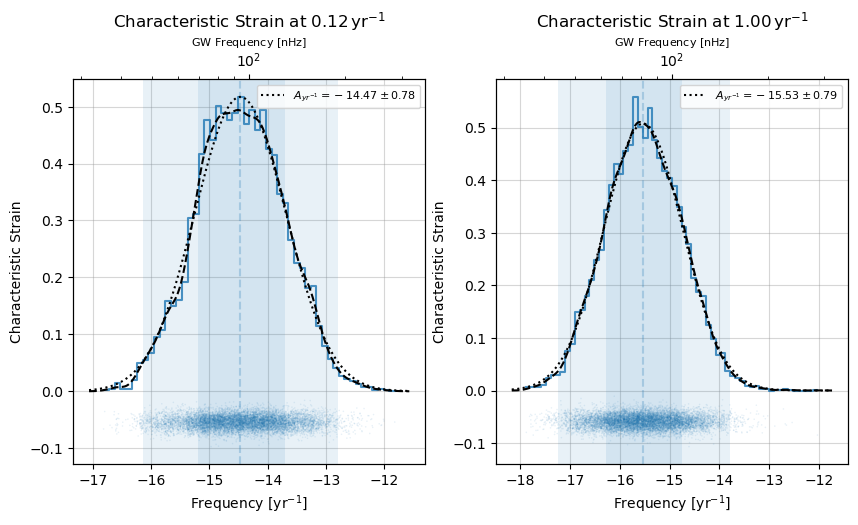

Saved to /Users/lzkelley/Programs/nanograv/15yr_astro_libraries/uniform-07a-rot_new_n1000_r1000_f40/hc-amp_fyr-0.10-1.00_skip-100.png, size 612.6 KiB


PosixPath('/Users/lzkelley/Programs/nanograv/15yr_astro_libraries/uniform-07a-rot_new_n1000_r1000_f40/hc-amp_fyr-0.10-1.00_skip-100.png')

In [51]:
fobs = library['fobs'][:]
fobs_yr = fobs * YR
target_freqs = [0.1, 1.0]
skip = 100

# Setup axes
ncols = len(target_freqs)
fig, axes = plot.figax(
    figsize=[10, 5], xlabel='Frequency $[\\mathrm{yr}^{-1}]$', ylabel='Characteristic Strain', ncols=ncols
)

strain_at_freqs = []

for ii, ax in enumerate(axes):
    plot._twin_hz(ax)

    tfreq = target_freqs[ii]
    df = np.fabs(fobs_yr - tfreq)
    ff = np.argmin(df)

    title = f"Characteristic Strain at ${fobs_yr[ff]:.2f} \, \\mathrm{{ yr}}^{{-1}}$"
    ax.set(xscale='linear', yscale='linear', title=title)

    hc = library['gwb'][:, ff, :]
    strain_at_freqs.append(hc)
    
    idx = (hc.flatten() > 0.0)
    yy = np.log10(hc.flatten()[idx])
    if skip is not None:
        np.random.shuffle(yy)
        yy = yy[::skip]
    
    kale.dist1d(yy, ax=ax, density=False, carpet=True, confidence=True, quantiles=[0.68, 0.98])
    med = np.median(yy)
    std = np.std(yy)

    edges = kale.utils.spacing(yy, 'linear', 300, stretch=0.1)
    xx, yy = kale.density(yy, points=edges, probability=True)
    ax.plot(xx, yy, 'k--')

    popt, pcov = utils.fit_gaussian(xx, yy, [1.0, -15, 2.0])
    print(popt)
    yy = utils._func_gaussian(xx, *popt)
    ax.plot(xx, yy, 'k:', label=f"$A_{{{{yr}}^{{-1}}}} = {popt[1]:.2f} \pm {popt[2]:.2f}$")

    # lab = f"${plot.scientific_notation(obs_amp_med, dollar=False)} = 10^{{{np.log10(obs_amp_med):.2f}}}$"
    # ax.axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5, label=lab)
    # ax.axvspan(*np.log10(obs_amp_5_95), color='r', alpha=0.1, label="[5,95]%")

    ax.legend(fontsize=8)

plt.show()
flab = "-".join([f"{tf:.2f}" for tf in target_freqs])
skip_str = "" if skip in [None, 1] else f"_skip-{skip}"
fname = f"hc-amp_fyr-{flab}{skip_str}.png"
save_fig(fig, fname)

1.80e+01/1.00e+03 = 1.80e-02


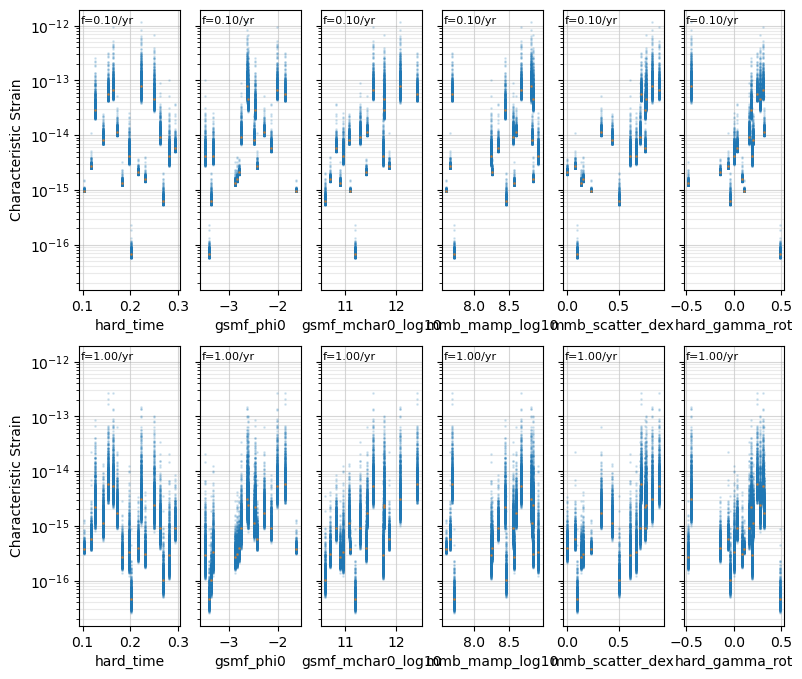

In [56]:
npar = len(param_names)
fig, axes = plot.figax(
    figsize=[3*np.sqrt(npar), 8], nrows=len(strain_at_freqs), ncols=npar,
    sharey=True, xscale='linear',
    left=0.03, right=0.99
)

for jj, axrow in enumerate(axes):
    hc = strain_at_freqs[jj]
    for ii, (pn, ax) in enumerate(zip(param_names, axrow)):
        ax.set(xlabel=pn)
        plt.text(0.02, 0.98, f"f={target_freqs[jj]:.2f}/yr", ha='left', va='top', transform=ax.transAxes, fontsize=8)
        if ii == 0:
            ax.set_ylabel('Characteristic Strain')
        xx = params[:, ii]
        ax.scatter(xx[:, np.newaxis] * np.ones_like(hc), hc, alpha=0.15, marker='.', s=4)
        ax.scatter(xx, np.median(hc, axis=-1), alpha=0.5, marker='.', s=4)

plt.show()
flab = "-".join([f"{tf:.2f}" for tf in target_freqs])
fname = f"hc-amp_fyr-{flab}_vs-params.png"
save_fig(fig, fname)

## Spectra Examples

use_num=2
Saved to /Users/lzkelley/Programs/nanograv/15yr_astro_libraries/uniform-07a-rot-test_new_n128_r100_f40/spectra-examples_N2.png, size 761.6 KiB


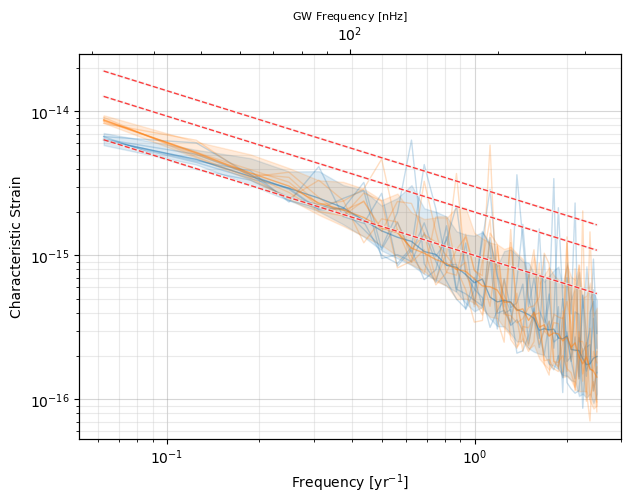

In [47]:
num_label = 5
# data['gwb'].shape

NUM = 100
# percs = [25, 75]
percs = [10, 90]

fobs = library['fobs'][:]
xx = fobs * YR
fig, ax = plot.figax(xlabel='Frequency $[\\mathrm{yr}^{-1}]$', ylabel='Characteristic Strain')
plot._twin_hz(ax)
# ax.set(ylim=[1e-18, 3e-13])

# (nsamples, nfreqs, nreals)
yy = library['gwb'][:]

nsamp = yy.shape[0]
choose = np.min([NUM, nsamp])
# sel = np.random.choice(nsamp, choose, replace=False)
sel = np.asarray([73, 87])
yy = yy[sel]

# ==> (nfreqs, nsamples, nreals)
yy = np.moveaxis(yy, 1, 0)

med = np.median(yy, axis=-1)

use_num = np.min([NUM, sel.size])
print(f"{use_num=}")

for ii in range(use_num):
    cc, = ax.plot(xx, med[:, ii], alpha=0.5, lw=1) # , color='b')
    cc = cc.get_color()

    conf = np.percentile(yy[:, ii, :], percs, axis=-1)
    ax.fill_between(xx, *conf, alpha=0.15, color=cc, lw=1)

    zz = yy[:, ii, :5]
    zz = zz.reshape(zz.shape[0], -1)
    ax.plot(xx, zz, alpha=0.25, color=cc, lw=1)

for amp in [1e-15, 2e-15, 3e-15]:
    hh = plot._draw_plaw(ax, xx, amp, 1.0, color='0.95', alpha=0.70, zorder=99, lw=2.0, ls='-')
    plot._draw_plaw(ax, xx, amp, 1.0, color='r', alpha=0.75, zorder=100, lw=1.0)

fname = f"spectra-examples_N{use_num}.png"
save_fig(fig, fname)
plt.show()

1 2
Saved to /Users/lzkelley/Programs/nanograv/15yr_astro_libraries/uniform-07a-rot-test_new_n128_r100_f40/spectra-examples_each-param_skip10.png, size 1004.1 KiB


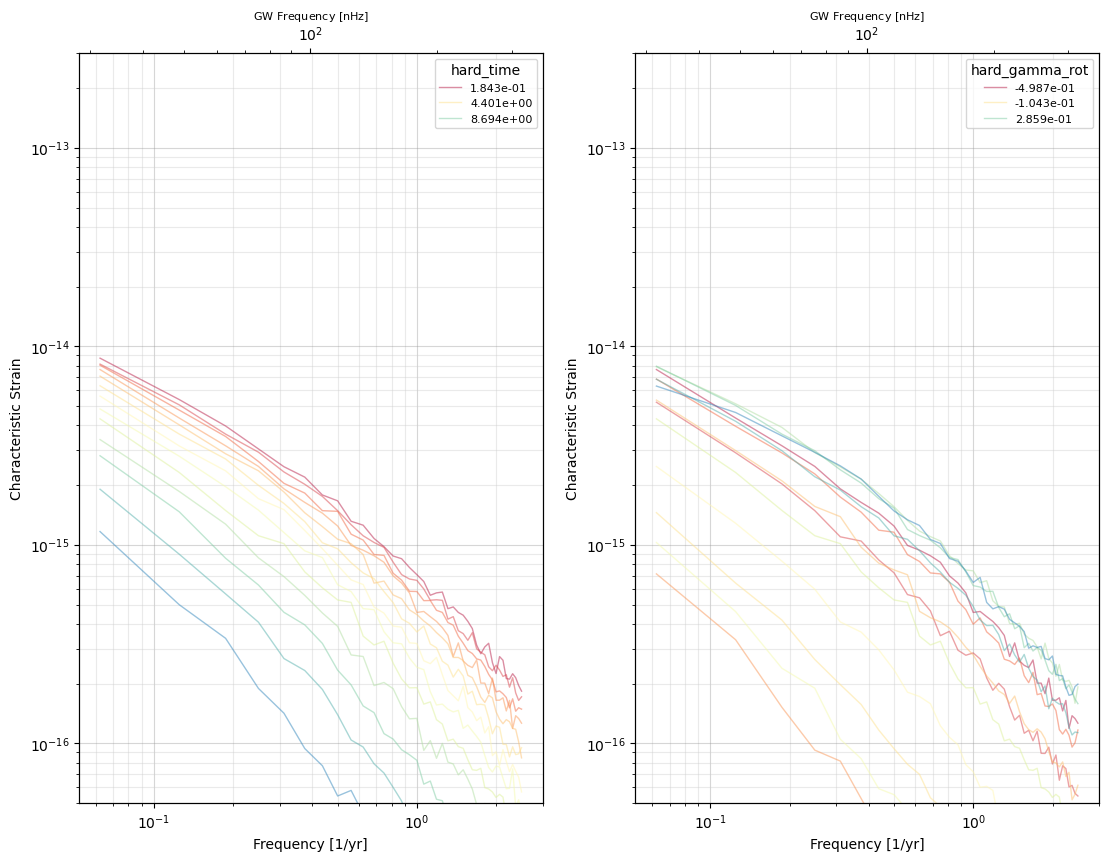

In [7]:
percs = [25, 75]
data = library
xx = data['fobs'][:] * YR
gwb = data['gwb'][:]
spars = data['sample_params'][:]
# print(gwb.shape, spars.shape)
# print(f"{len(data.attrs['param_names'])=}")

num_params = len(param_names)
ncols = 2
nrows = int(np.ceil(num_params/ncols))
print(nrows, ncols)

fig, axes = plot.figax(
    figsize=[12, 10], ylim=[0.5e-16, 3e-13], left=0.13, bottom=0.13, right=0.98, top=0.88,
    xlabel="Frequency [1/yr]", ylabel="Characteristic Strain", nrows=nrows, ncols=ncols,
)


spars = spars.T
for ii, pname in enumerate(data.attrs['param_names']):
    ax = axes.flatten()[ii]
    plot._twin_hz(ax)
    pname = pname.decode()

    vals = spars[ii].copy()
    sort_idx = np.argsort(vals)
    sv = vals[sort_idx]
    gwb = data['gwb'][:].copy()[sort_idx]

    num = gwb.shape[0]
    colors = mpl.colormaps['Spectral'](np.linspace(0.05, 0.95, num))

    skip = 10
    for jj, pv in enumerate(sv):
        if jj % skip != 0:
            continue
        # Make sure there are only `num_label` labeled lines on the plot
        label = (jj % (num//num_label) == 0) or (num <= num_label) or (jj == num - 1)
        cc = colors[jj]

        yy = gwb[jj]
        med = np.median(yy, axis=-1)
        conf = np.percentile(yy, percs, axis=-1)
        label = f"{pv:.3e}" if label else ""
        ax.plot(xx, med, color=colors[jj], label=label, lw=1.0, alpha=0.5)
        # ax.fill_between(xx, *conf, color=colors[jj], alpha=0.2, lw=0.5)
        
    ax.legend(title=pname, fontsize=8, loc='upper right')
    # output_path = Path(holo._PATH_OUTPUT, f'eccen-lib_{pname}_skip-{skip}.png')
    # fig.savefig(output_path, dpi=300)
    

fname = f"spectra-examples_each-param_skip{skip}.png"
save_fig(fig, fname)
plt.show()


## Param space corner plot

In [ ]:
spars = library['sample_params'][:].copy()
idx = np.ones_like(spars[:, 0], dtype=bool)
for sp in spars.T:
    extr = np.percentile(sp, [1, 99])
    idx = idx & (extr[0] < sp) & (sp < extr[1])

names = [dd.decode() for dd in library.attrs['param_names']]
corner, _ = kale.corner(spars[idx].T, dist2d=dict(contour=False), dist1d=dict(probability=True, density=False, hist=True), labels=names, kwcorner=dict(figsize=[8, 8]))
fig = corner.fig
plt.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.96)

plt.show()
fname = f"param-space_corner.png"
save_fig(fig, fname)


## Fits

In [ ]:
CREATE = False
RECREATE = False
fits_path = holo.librarian.get_fits_path(lib_path)
print(f"{fits_path=} {fits_path.exists()}")
if CREATE or RECREATE:
    if (CREATE and (not fits_path.exists())) or RECREATE:
        holo.librarian.fit_library_spectra(lib_path, log, recreate=RECREATE)
    
assert fits_path.is_file()
with np.load(fits_path) as fits:
    print(list(fits.keys()))

### Power-Law

In [ ]:
with np.load(fits_path) as fits:
    nbins_plaw = fits['nbins_plaw']
    fits_plaw = fits['fits_plaw']

med = np.median(fits_plaw, axis=1)
std = np.std(fits_plaw, axis=1)

skip = None

len_nbins = len(nbins_plaw)
fig, axes = plt.subplots(figsize=[12, 6], nrows=3, ncols=len_nbins, sharey='row')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

axrow = axes[0, :]
for ii in range(len_nbins):
    ax = axes[0, ii]
    ax.set_title(f"num fbins: {nbins_plaw[ii]}")
    ax.axvline(-15, ls='--', color='0.5', alpha=0.5, zorder=1000)
    ax.axhline(-13/3, ls='--', color='0.5', alpha=0.5, zorder=1000)
    xx, yy = med[::skip, ii, :].T
    kale.dist2d([xx, yy], hist=False, ax=ax, median=False)

    ax = axes[1, ii]
    ax.set(xlabel='log10(amp)', ylabel='stdev')
    ax.scatter(xx, std[::skip, ii, 0], s=4, alpha=0.5)

    ax = axes[2, ii]
    ax.set(xlabel='gamma', ylabel='stdev')
    ax.scatter(yy, std[::skip, ii, 1], s=4, alpha=0.5)


plt.show()
skip_str = "" if skip in [0, 1, None] else f"_skip{skip}"
fname = f"plaw-fits{skip_str}.png"
save_fig(fig, fname)


### Turn-over

In [ ]:
with np.load(fits_path) as fits:
    nbins = fits['nbins_turn']
    fits = fits['fits_turn']
    # fits[:, :, :, 2] = np.log10(fits[:, :, :, 2])
    fits[:, :, :, 2] = fits[:, :, :, 2] * 1e9
    
names = ['log10(amp)', 'gamma', 'fbreak [nHz]', 'kappa']
med = np.median(fits, axis=1)

skip = None

len_nbins = len(nbins)

for ii in range(len_nbins):
    nb = nbins[ii]
    vals = med[:, ii, :]
    idx = np.all(np.isfinite(vals), axis=-1)

    corner, _ = kale.corner(vals[idx].T, kwcorner=dict(figsize=[8, 8]), labels=names)
    fig = corner.fig
    fig.text(0.99, 0.01, f"num freq bins: {nb}", ha='right', va='bottom', fontsize=10)

    skip_str = "" if skip in [0, 1, None] else f"_skip{skip}"
    fname = f"turn-fits_nbins{nb}{skip_str}.png"
    save_fig(fig, fname)

plt.show()


# Compare Libraries

## Power-Law Fits

In [ ]:
path_output = Path(holo._PATH_OUTPUT).joinpath("share")
paths = [
    "astro-01-gw_2023-03-03_n10000_s61-81-101_r100_f40_SHARE",
    "astro-02-gw_2023-03-03_n10000_s61-81-101_r100_f40_SHARE",
    "astro-tight-02-gw_2023-03-03_n10000_s61-81-101_r100_f40_SHARE",
    "broad-uniform-01-gw_2023-03-03_n10000_s61-81-101_r100_f40_SHARE"
]
fname = "sam_lib.hdf5"
files = []
for path in paths:
    file = path_output.joinpath(path, fname)
    files.append(file)
    print(f"{file.parts[-2]} :: exists = {file.exists()}")

In [ ]:
skip_reals = 6
skip_samps = 6
num_bins = 10

handles = []
labels = []
axes = None
for fil in files:
    lab = fil.parts[-2].split("_")[0]
    print(lab)
    with h5py.File(fil, 'r') as data:
        lamp = data['fit_lamp']
        plaw = data['fit_plaw']
        nbins = data.attrs['fit_nbins'].tolist()
        lamp = lamp[::skip_samps, ::skip_reals, :].reshape(-1, len(nbins))
        plaw = plaw[::skip_samps, ::skip_reals, :].reshape(-1, len(nbins))

    nb_idx = nbins.index(num_bins)
    aa = lamp[:, nb_idx]
    bb = plaw[:, nb_idx]

    idx = np.isfinite(aa) & np.isfinite(bb)
    corner = kale.Corner(
        [aa[idx], bb[idx]],
        limits=[[-18, -13], [-2, 0]],
        labels=['$\log10(A_{\mathrm{yr}^{-1}})$', '$\gamma_\mathrm{h}$'],
        axes=axes
    )
    hand = corner.plot(
        dist1d=dict(carpet=False, confidence=False),
        dist2d=dict(scatter=False, hist=False, median=False, sigmas=[1, 2]),
    )
    handles.append(hand)
    labels.append(lab)
    fig = corner.fig
    axes = corner.axes

for ax in axes.flatten():
    ax.grid(True, alpha=0.25)

# TL    
axes[1, 0].axhline(-2.0/3.0, color='k', ls='--', alpha=0.5)
axes[1, 0].axhline(obs_plaw, color='r', ls='--', alpha=0.5)
axes[1, 0].axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5)
axes[1, 0].axvspan(*np.log10(obs_amp_5_95), color='r', ls='--', alpha=0.15)

# BL
axes[0, 0].axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5)
axes[0, 0].axvspan(*np.log10(obs_amp_5_95), color='r', ls='--', alpha=0.15)

# TR
axes[1, 1].axhline(-2.0/3.0, color='k', ls='--', alpha=0.5)
axes[1, 1].axhline(obs_plaw, color='r', ls='--', alpha=0.5)
    
corner.legend(handles, labels, title='n bins')
plt.show()
fname = f"comparison_all-plaw-fits_skip-s{skip_samps}-r{skip_reals}.png"
fname = Path(holo._PATH_OUTPUT).joinpath(fname)
fig.savefig(fname, dpi=400)
print(f"Saved to {fname}, size {utils.get_file_size(fname)}")


## General

In [ ]:
path_output = Path(holo._PATH_OUTPUT).resolve()
paths = [
    "ps-test-uniform_2023-03-01_n200_s50_r100_f40_SHARE",
    "ps-test-normal_2023-03-01_n200_s50_r100_f40_SHARE",
]
fname = "sam_lib.hdf5"
files = []
for path in paths:
    file = path_output.joinpath(path, fname)
    files.append(file)
    print(file.name, file.exists())

In [ ]:
fig, axes = plt.subplots(figsize=[10, 5], ncols=2, sharey=True, sharex=True)
for ax, file in zip(axes, files):
    ax.set(xscale='log', yscale='log')
    ax.grid(True, alpha=0.25)
    temp = file.parts[-2].split("_")[0].split("-")[-1]
    ax.set_title(temp, fontsize=12)
    data = h5py.File(file, 'r')

    fobs = data['fobs'][()]
    gwb = data['gwb'][()]
    nsamp, _, nreal = gwb.shape
    for ii in range(nsamp):
        plot.draw_gwb(ax, fobs, gwb[ii])
    
plt.show()


In [ ]:
nbins = [5, 10, 15, 0]

fit_keys = ['fit_lamp', 'fit_plaw']

for file in files:
    label = file.parts[-2].split("_")[0].split("-")[-1]
    data = h5py.File(file, 'r')
    lamp = data['fit_lamp'][:, :, 1]
    plaw = data['fit_plaw'][:, :, 1]
    vals = [lamp.flatten(), plaw.flatten()]
    vals = [vv[::10] for vv in vals]
    idx = np.ones_like(vals[0], dtype=bool)
    for vv in vals:
        lo, hi = np.percentile(vv, [2, 98])
        idx = idx & (lo < vv) & (vv < hi)
        
    vals = [vv[idx] for vv in vals]
    corner, _ = kale.corner(vals)
    corner.fig.text(0.5, 0.5, label, va='center', ha='center')
    
plt.show()


In [ ]:
fig, axes = plt.subplots(figsize=[10, 5], ncols=2, nrows=2, sharex='col')
nbins = [5, 10, 15, 0]

fit_keys = ['fit_lamp', 'fit_plaw']

for (ii, jj), ax in np.ndenumerate(axes):
    file = files[ii]
    ax.set(xscale='linear', yscale='linear')
    ax.grid(True, alpha=0.25)
    temp = file.parts[-2].split("_")[0].split("-")[-1]
    ax.set_title(temp, fontsize=12)
    data = h5py.File(file, 'r')

    key = fit_keys[jj]
    temp = data[key][:, :, 1]
    ave = np.mean(temp, axis=-1)
    print(utils.stats(ave))
    # kale.dist1d(ave, ax=ax)
    kale.dist1d(temp.flatten(), ax=ax)
    
    
plt.show()


## Single File

In [ ]:
# fname = (
#     "/Users/lzkelley/programs/nanograv/holodeck/output/"
#     "hard04b_2023-01-23_01_n1000_g100_s40_r50_f40/"
#     "sam-lib_hard04b_2023-01-23_01_n1000_g100_s40_r50_f40.hdf5"
# )
# fname = "/Users/lzkelley/Programs/nanograv/holodeck/output/hard04b_2023-01-23_01_n1000_g100_s40_r50_f40/sam-lib_hard04b_2023-01-23_01_n1000_g100_s40_r50_f40.hdf5"

# fname = "/Users/lzkelley/programs/nanograv/holodeck/output/eccen-02_2023-01-31_02_n100_s30_r100_f20/sam_lib.hdf5"
# FNAME = "/Users/lzkelley/programs/nanograv/holodeck/output/big-circ-01_2023-02-02_01_n2000_s40_r100_f40/sam_lib.hdf5"
FNAME = (
    "/Users/lzkelley/programs/nanograv/holodeck/output/savio-runs/"
    "astro-01_2023-03-03_n10000_s61-81-101_r100_f40_SHARE/sam_lib.hdf5"
)

path = Path(FNAME)

# with h5py.File(FNAME, 'r') as data:
data = h5py.File(path, 'r')
print("Keys:", data.keys())
for kk, vv in data.items():
    try:
        print("\t", kk, vv.shape)
    except AttributeError:
        continue
    
print("\nAttributes:")
for kk, vv in data.attrs.items():
    print("\t", kk, vv)
    
# print("\nParameters:")
# for kk, vv in data['parameters'].items():
#     print("\t", kk, vv[:])


In [ ]:
fobs = data['fobs'][:]
xx = fobs * YR
fig, ax = plot.figax(xlabel='Frequency $[\\mathrm{yr}^{-1}]$', ylabel='Characteristic Strain')
plot._twin_hz(ax)

df = np.fabs(xx - 1.0)
ff = np.argmin(df)
title = f"Characteristic Strain at ${xx[ff]:.2f} \, \\mathrm{{ yr}}^{{-1}}$"
ax.set(xscale='linear', yscale='linear', xlim=[-18, -13], title=title)
hcyr = data['gwb'][:, ff, :]
idx = (hcyr.flatten() > 0.0)
yy = np.log10(hcyr.flatten()[idx])
kale.dist1d(yy, ax=ax, density=False, carpet=True, confidence=True, quantiles=[0.68, 0.98])
med = np.median(yy)
std = np.std(yy)
fig.text(0.99, 0.99, f"med: {med:.2f}, std: {std:.2f}", ha='right', va='top', fontsize=8)

xx = np.linspace(-18, -13, 100)
xx, yy = kale.density(yy, points=xx, probability=True)
ax.plot(xx, yy, 'b--')

popt, pcov = utils.fit_gaussian(xx, yy, [1.0, -15, 2.0])
print(popt)
yy = utils._func_gaussian(xx, *popt)
ax.plot(xx, yy, 'k:', label=f"$A_{{{{yr}}^{{-1}}}} = {popt[1]:.2f} \pm {popt[2]:.2f}$")

lab = f"${plot.scientific_notation(obs_amp_med, dollar=False)} = 10^{{{np.log10(obs_amp_med):.2f}}}$"

ax.axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5, label=lab)
ax.axvspan(*np.log10(obs_amp_5_95), color='r', alpha=0.1, label="[5,95]%")

ax.legend(fontsize=8)
plt.show()
fname = path.parent.joinpath("hc-amp-inv-yr.png")
fig.savefig(fname, dpi=400)
print(f"Saved to {fname}, size {utils.get_file_size(fname)}")

In [ ]:
pnames = [pn.decode() for pn in data.attrs['param_names']]
print(pnames)
npar = len(pnames)
fig, axes = plot.figax(
    figsize=[5*np.sqrt(npar), 5], ncols=npar,
    sharey=True, xscale='linear',
    left=0.03, right=0.99
)
for ii, (pn, ax) in enumerate(zip(pnames, axes)):
    ax.set(xlabel=pn)
    if ii == 0:
        ax.set_ylabel('Characteristic Strain')
    vals = data['sample_params'][:, ii]
    idx = np.argsort(vals)
    xx = vals[idx]
    ax.scatter(xx[:, np.newaxis] * np.ones_like(hcyr), hcyr[idx], alpha=0.15, marker='.', s=4)
    ax.scatter(xx, np.median(hcyr, axis=-1)[idx], alpha=0.5, marker='.', s=4)

    ax.axhline(obs_amp_med, color='r', ls='--', alpha=0.5)
    ax.axhspan(*obs_amp_5_95, color='r', alpha=0.1)

fname = path.parent.joinpath("hc-amp-inv-yr_parameters.png")
fig.savefig(fname, dpi=200)
print(f"Saved to {fname}, size {utils.get_file_size(fname)}")
plt.show()

# Power-Law Fits

In [ ]:
lamp = data['fit_med_lamp']
plaw = data['fit_med_plaw']
nbins = data.attrs['fit_nbins']
print(lamp.shape, nbins)

handles = []
labels = []
axes = None
for ii in range(len(nbins)):
    # aa = lamp[::40, ii]
    # bb = plaw[::40, ii]
    aa = lamp[:, ii]
    bb = plaw[:, ii]
    idx = np.isfinite(aa) & np.isfinite(bb)
    corner = kale.Corner(
        [aa[idx], bb[idx]],
        limits=[[-20, -12], [-3, 2]],
        labels=['$\log10(A_{\mathrm{yr}^{-1}})$', '$\gamma_\mathrm{h}$'],
        axes=axes
    )
    hand = corner.plot(
        dist1d=dict(carpet=False, confidence=False),
        dist2d=dict(scatter=False, hist=False, median=False, sigmas=[1, 2]),
    )
    handles.append(hand)
    lab = nbins[ii] 
    lab = f"{lab}" if (lab is not None) and (lab > 0) else "all"
    labels.append(lab)
    fig = corner.fig
    axes = corner.axes

for ax in axes.flatten():
    ax.grid(True, alpha=0.25)

# TL    
axes[1, 0].axhline(-2.0/3.0, color='k', ls='--', alpha=0.5)
axes[1, 0].axhline(obs_plaw, color='r', ls='--', alpha=0.5)
axes[1, 0].axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5)
axes[1, 0].axvspan(*np.log10(obs_amp_5_95), color='r', ls='--', alpha=0.15)

# BL
axes[0, 0].axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5)
axes[0, 0].axvspan(*np.log10(obs_amp_5_95), color='r', ls='--', alpha=0.15)

# TR
axes[1, 1].axhline(-2.0/3.0, color='k', ls='--', alpha=0.5)
axes[1, 1].axhline(obs_plaw, color='r', ls='--', alpha=0.5)
    
corner.legend(handles, labels, title='n bins')
fname = path.parent.joinpath("med-plaw-fits.png")
fig.savefig(fname, dpi=400)
print(f"Saved to {fname}, size {utils.get_file_size(fname)}")
plt.show()


In [ ]:
lamp = data['fit_lamp']
print(lamp.shape)

In [ ]:
skip_reals = 10
skip_samps = 10

lamp = data['fit_lamp']
plaw = data['fit_plaw']
print(lamp.shape, lamp.size)

nbins = data.attrs['fit_nbins']
lamp = lamp[::skip_samps, ::skip_reals, :].reshape(-1, len(nbins))
plaw = plaw[::skip_samps, ::skip_reals, :].reshape(-1, len(nbins))
print(lamp.shape, lamp.size)

handles = []
labels = []
axes = None
for ii in range(len(nbins)):
    aa = lamp[:, ii]
    bb = plaw[:, ii]
    # aa = lamp[:, ii]
    # bb = plaw[:, ii]
    idx = np.isfinite(aa) & np.isfinite(bb)
    corner = kale.Corner(
        [aa[idx], bb[idx]],
        limits=[[-20, -12], [-3, 2]],
        labels=['$\log10(A_{\mathrm{yr}^{-1}})$', '$\gamma_\mathrm{h}$'],
        axes=axes
    )
    hand = corner.plot(
        dist1d=dict(carpet=False, confidence=False),
        dist2d=dict(scatter=False, hist=False, median=False, sigmas=[1, 2]),
    )
    handles.append(hand)
    lab = nbins[ii] 
    lab = f"{lab}" if (lab is not None) and (lab > 0) else "all"
    labels.append(lab)
    fig = corner.fig
    axes = corner.axes

for ax in axes.flatten():
    ax.grid(True, alpha=0.25)

# TL    
axes[1, 0].axhline(-2.0/3.0, color='k', ls='--', alpha=0.5)
axes[1, 0].axhline(obs_plaw, color='r', ls='--', alpha=0.5)
axes[1, 0].axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5)
axes[1, 0].axvspan(*np.log10(obs_amp_5_95), color='r', ls='--', alpha=0.15)

# BL
axes[0, 0].axvline(np.log10(obs_amp_med), color='r', ls='--', alpha=0.5)
axes[0, 0].axvspan(*np.log10(obs_amp_5_95), color='r', ls='--', alpha=0.15)

# TR
axes[1, 1].axhline(-2.0/3.0, color='k', ls='--', alpha=0.5)
axes[1, 1].axhline(obs_plaw, color='r', ls='--', alpha=0.5)
    
corner.legend(handles, labels, title='n bins')
fname = f"all-plaw-fits_skip-s{skip_samps}-r{skip_reals}.png"
fname = path.parent.joinpath(fname)
fig.savefig(fname, dpi=400)
print(f"Saved to {fname}, size {utils.get_file_size(fname)}")
plt.show()


# Plot spectra versus different parameters

In [ ]:
percs = [25, 75]
xx = data['fobs'][:] * YR
gwb = data['gwb'][:]
spars = data['sample_params'][:]
print(gwb.shape, spars.shape)
# print(f"{len(data.attrs['param_names'])=}")

spars = spars.T
for ii, pname in enumerate(data.attrs['param_names']):
    pname = pname.decode()
    fig, ax = plot.figax(
        figsize=[6, 4], ylim=[0.5e-16, 3e-13], left=0.13, bottom=0.13, right=0.98, top=0.88,
        xlabel="Frequency [1/yr]", ylabel="Characteristic Strain",
    )
    plot._twin_hz(ax)

    vals = spars[ii].copy()
    sort_idx = np.argsort(vals)
    sv = vals[sort_idx]
    gwb = data['gwb'][:].copy()[sort_idx]

    num = gwb.shape[0]
    colors = mpl.cm.get_cmap('Spectral')(np.linspace(0.05, 0.95, num))

    skip = 10
    for jj, pv in enumerate(sv):
        if jj % skip != 0:
            continue
        # Make sure there are only `num_label` labeled lines on the plot
        label = (jj % (num//num_label) == 0) or (num <= num_label) or (jj == num - 1)
        cc = colors[jj]

        yy = gwb[jj]
        med = np.median(yy, axis=-1)
        conf = np.percentile(yy, percs, axis=-1)
        label = f"{pv:.3e}" if label else ""
        ax.plot(xx, med, color=colors[jj], label=label, lw=1.0, alpha=0.5)
        # ax.fill_between(xx, *conf, color=colors[jj], alpha=0.2, lw=0.5)
        
    ax.legend(title=pname, fontsize=8, loc='upper right')
    output_path = Path(holo._PATH_OUTPUT, f'eccen-lib_{pname}_skip-{skip}.png')
    fig.savefig(output_path, dpi=300)
    
plt.show()

# Spectral Fits

In [ ]:
path = (
    "/Users/lzkelley/Programs/nanograv/15yr_astro_libraries/"
    # "broad-uniform-02b/broad-uniform-02b_10k"
    "astro-02-gw"
)
path = Path(path)
sim_path = path.joinpath("sam_lib.hdf5")
print(path.exists(), sim_path.exists())
data = h5py.File(sim_path, 'r')


In [ ]:
nbins = 14
shape = np.shape(data['gwb'])
print(f"{shape=}")
nsamp, freqs, nreals = shape

fit_shape = (nsamp, nreals,)
fit_med_shape = (nsamp, )

fit_plaw = np.zeros(fit_shape + (2,))
fit_plaw_med = np.zeros(fit_med_shape + (2,))

fit_turn = np.zeros(fit_shape + (4,))
fit_turn_med = np.zeros(fit_med_shape + (4,))

psd = np.zeros(shape)

failures = 0
for ss in tqdm.tqdm(range(nsamp)):
    # for ss in range(170, 180):
    fobs = data['fobs'][:]
    # xx = fobs*YR
    gwb = data['gwb'][ss, :, :]
    psd[ss, ...] = holo.utils.char_strain_to_psd(fobs[:, np.newaxis], gwb)

    fits = holo.librarian.fit_spectra_plaw(fobs, psd[ss], [nbins])

    nb, fit_plaw[ss, ...], fit_plaw_med[ss, ...] = fits

    try:
        fits = holo.librarian.fit_spectra_turn(fobs, psd[ss], [nbins])
        nb, fit_turn[ss, ...], fit_turn_med[ss, ...] = fits
    except Exception as err:
        failures += 1
        print(f"Failed on {ss}!")
        fit_turn[ss, ...] = np.nan
        fit_turn_med[ss, ...] = np.nan
        # fig, ax = plot.figax()
        # plot.draw_gwb(ax, fobs, psd[ss])
        # plt.show()
        
    break
        
# print(f"failures on {failures} spectra!")

# fname = f"{path.parts[-1]}_{nbins}f-fits.npz"
# np.savez(fname, fobs=fobs, gwb_hc=data['gwb'][:], gwb_psd=psd,
#          fit_plaw=fit_plaw, fit_plaw_med=fit_plaw_med,
#          fit_turn=fit_turn, fit_turn_med=fit_turn_med)
# print(f"Saved to {fname}, size {utils.get_file_size(fname)}")


In [ ]:
fname = "astro-02-gw_14f-fits.npz"
fname_2 = "_astro-02-gw_14f-fits.npz"
data_in = np.load(fname)
data_out = {}
for key in data_in.keys():
    vals = data_in[key]
    if key in ['fit_plaw', 'fit_turn']:
        print("\n")
        print(key, vals.shape)
        temp = vals[..., 0]
        
        print(temp)
        temp = (10.0 ** temp)
        # print(temp)
        temp = temp * np.power(1/YR, -3/2)
        # print(temp)
        temp = np.log10(temp)
        print(temp)

        vals[..., 0] = temp

    # if key in ['gwb_psd']:
    #     print(key, vals.shape)
    #     vals = vals * np.power(1/YR, -3)

    data_out[key] = vals

np.savez(fname_2, **data_out)

In [ ]:
fname = "_astro-02-gw_14f-fits.npz"
ss = 0

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

YR = 31557600.0

fits = np.load(fname)

fig, ax = plt.subplots()
ax.set(yscale='log', xscale='log')
fobs = fits['fobs'][:]
xx = fobs*YR
# xx = fobs
# mod = 1.0
mod = xx ** 4

def func_powerlaw(freqs, fref, log10_amp, index):
    amp = 10.0 ** log10_amp
    aa = (amp**2) / (12.0 * np.pi**2)
    yy = aa * np.power(freqs/fref, index) * np.power(fref, -3)
    return yy

def func_turnover(freqs, fref, log10_amp, gamma, fbreak, kappa):
    amp = 10.0 ** log10_amp
    bend = np.power(fbreak/freqs, kappa)
    bend = np.power(1.0 + bend, -1.0)
    aa = (amp**2) / (12 * np.pi**2)
    yy = aa * np.power(freqs/fref, gamma) * bend * np.power(fref, -3)
    return yy

kw = dict(lw=2.0, alpha=0.35)

psd = fits['gwb_psd']
nreals =  np.shape(psd)[-1]

# med = np.median(psd[ss], axis=-1)
# ax.plot(xx, med*mod, color='k', **kw)

# plaw = fits['fit_plaw_med'][ss]
# zz = func_powerlaw(fobs, 1/YR, *plaw)
# ax.plot(xx, zz*mod, color='k', ls='--', **kw)

# turn = fits['fit_turn_med'][ss]
# zz = func_turnover(fobs, 1/YR, *turn)
# ax.plot(xx, zz*mod, color='k', ls=':', **kw)

sel_idx = np.random.choice(nreals, 3, replace=False)
for idx in sel_idx:
    cc, = ax.plot(xx, psd[ss, :, idx]*mod, ls='-', lw=0.75, alpha=0.75)
    cc = cc.get_color()

    # plaw = fits['fit_plaw'][ss, idx]
    # zz = func_powerlaw(fobs, 1/YR, *plaw)
    # ax.plot(xx, zz*mod, color=cc, ls='--', **kw)

    turn = fits['fit_turn'][ss, idx]
    zz = func_turnover(fobs, 1/YR, *turn)
    ax.plot(xx, zz*mod, color=cc, ls=':', **kw)    
    
plt.show()

In [ ]:
hc = fits['gwb_hc'][ss]
psd = fits['gwb_psd'][ss]
fobs = fits['fobs']
print(fobs)
fig, ax = plt.subplots()
ax.set(yscale='log', xscale='log')

check = np.power(hc, 2) / (12*np.pi**2)
check = check * np.power(fobs*YR, -3)[:, np.newaxis] * np.power(1/YR, -3)
# ax.plot(fobs, np.median(hc, axis=-1))
ax.plot(fobs, np.median(psd, axis=-1) * np.power(1/YR, -3))
ax.plot(fobs, np.median(check, axis=-1), ls='--')

plt.show()

In [ ]:
idx = 1234
fobs = data['fobs'][:]
gwb = data['gwb'][idx, :, :]
# gwb = holo.utils.char_strain_to_psd(fobs[:, np.newaxis], gwb)

fig, ax = plot.figax()

xx = fobs*YR
yy = np.median(gwb, axis=-1)
ax.plot(xx, yy, lw=2.0, alpha=0.75)

zz = holo.utils._func_broken_plaw(fobs, 1.0/YR, 7.4e-17, -13/3, 0.29/YR, 2.8)
zz = holo.utils.psd_to_char_strain(fobs, zz)
ax.plot(xx, zz, 'r--', alpha=0.75)

fits = holo.utils.fit_broken_powerlaw(fobs, holo.utils.char_strain_to_psd(fobs, yy))
# fits = holo.utils.fit_broken_powerlaw(fobs, yy)
zz = holo.utils._func_broken_plaw(fobs, *fits)
zz = holo.utils.psd_to_char_strain(fobs, zz)
ax.plot(xx, zz, 'k--', alpha=0.75)

print(fits)
fits = [fits[0]*YR, fits[1], fits[2]*3, fits[3]*YR, fits[4]]
print(fits)

plt.show()

In [ ]:
idx = 1234
fobs = data['fobs'][:]
gwb = data['gwb'][idx, :, :]
# gwb = holo.utils.char_strain_to_psd(fobs[:, np.newaxis], gwb)

fig, ax = plot.figax()

xx = fobs*YR
yy = np.median(gwb, axis=-1)
ax.plot(xx, yy, lw=2.0, alpha=0.75)

zz = holo.utils._func_turnover_hc(xx, 1.0, 7.4e-17, -13/3, 0.3, 2.8)
ax.plot(xx, zz, 'r--', alpha=0.75)

fits = holo.utils.fit_turnover_hc(xx, yy)
zz = holo.utils._func_turnover_loglog_hc(np.log10(xx), *fits)
ax.plot(xx, 10.0**zz, 'k:', alpha=0.75, lw=3.0)
print(fits)
fits[0] = 10.0 ** fits[0]
print(fits)
zz = holo.utils._func_turnover_hc(xx, 1.0, *fits)
# zz = holo.utils._func_turnover_loglog(np.log10(xx), *fits)
ax.plot(xx, zz, 'k--', alpha=0.75)


plt.show()

In [ ]:
idx = 1234
fobs = data['fobs'][:]
gwb = data['gwb'][idx, :, :]
psd = holo.utils.char_strain_to_psd(fobs[:, np.newaxis], gwb)

fig, ax = plot.figax()

xx = fobs*YR
yy = np.median(psd, axis=-1)
ax.plot(xx, yy, lw=2.0, alpha=0.75)

zz = holo.utils._func_turnover_psd(fobs, 1/YR, 7.4e-17, -13/3, 0.3/YR, 2.8)
ax.plot(xx, zz, 'r--', alpha=0.75)

fits = holo.utils.fit_turnover_psd(fobs, yy, 1/YR)
print(fits)
fits[0] = 10.0 ** fits[0]
zz = holo.utils._func_turnover_psd(fobs, 1/YR, *fits)
ax.plot(xx, zz, 'k:', alpha=0.75, lw=3.0)


plt.show()